## Download the Datasets

In [ ]:
!kaggle datasets download -d birdy654/deep-voice-deepfake-voice-recognition
!unzip deep-voice-deepfake-voice-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
100% 3.68G/3.69G [02:23<00:00, 27.6MB/s]
100% 3.69G/3.69G [02:23<00:00, 27.5MB/s]
Archive:  deep-voice-deepfake-voice-recognition.zip
  inflating: DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-musk.wav  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from librosa.feature import melspectrogram
from librosa.core import amplitude_to_db
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.optim import lr_scheduler
import librosa as lb
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Data Preprocessing to make it mel spectrogram

In [ ]:
def get_mel_spectrogram(y: np.ndarray, sr: int = 22050, n_mels: int = 128) -> (np.ndarray, int):
    '''
    Compute a Mel spectrogram from an audio signal.

    Parameters:
    y (np.ndarray): Audio time series.
    sr (int): Sampling rate of `y`.
    n_mels (int): Number of Mel bands to generate.

    Returns:
    mel_spectrogram (np.ndarray): 2D array representing the Mel spectrogram.
    shape (tuple): Shape of the Mel spectrogram (number of Mel bands, number of frames).
    '''
    ms = lb.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    m = lb.power_to_db(ms,ref=np.max)

    return m, m.shape

def plot_mel_spectrogram(m: np.ndarray, sr: int = 22050, size: tuple = (8, 4), title: str = "Mel Spectrogram of Audio"):
    '''
    Plot a Mel spectrogram.

    Parameters:
    s (np.ndarray): Mel spectrogram to plot.
    sr (int, optional): Sampling rate of the audio. Default is 22050 Hz.
    size (tuple, optional): Size of the plot as (width, height). Default is (8, 4).
    title (str, optional): Title of the plot. Default is "Mel Spectrogram of Audio".
    '''

    plt.figure(figsize=size)
    lb.display.specshow(m, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

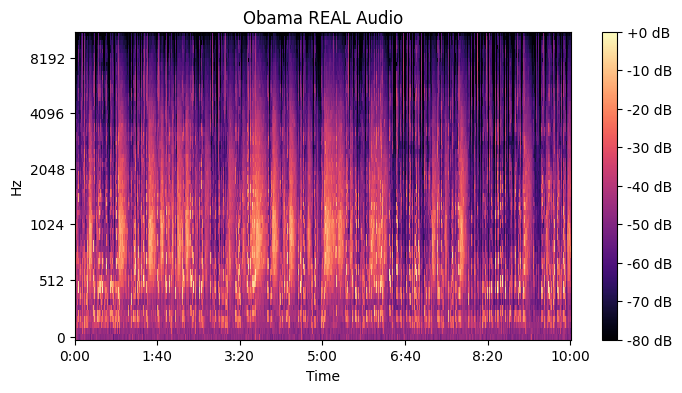

In [ ]:
# Load the audio file
file_path = 'KAGGLE/AUDIO/REAL/obama-original.wav'
waveform, sample_rate = lb.load(file_path)

# Compute the Mel spectrogram
mel_spectrogram, shape = get_mel_spectrogram(waveform, n_mels=64, sr= sample_rate)

# Plot the Mel spectrogram
plot_mel_spectrogram(mel_spectrogram, title = "Obama REAL Audio")


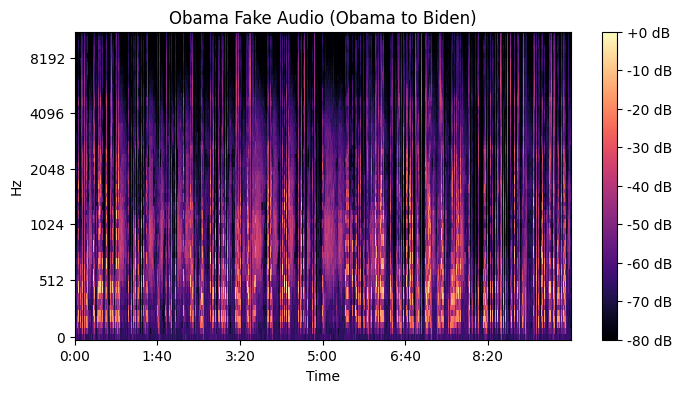

In [ ]:
# Load the audio file
file_path = 'KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav'
waveform, sample_rate = lb.load(file_path)

# Compute the Mel spectrogram
mel_spectrogram, shape = get_mel_spectrogram(waveform, n_mels=64, sr= sample_rate)

# Plot the Mel spectrogram
plot_mel_spectrogram(mel_spectrogram, title = "Obama Fake Audio (Obama to Biden)")

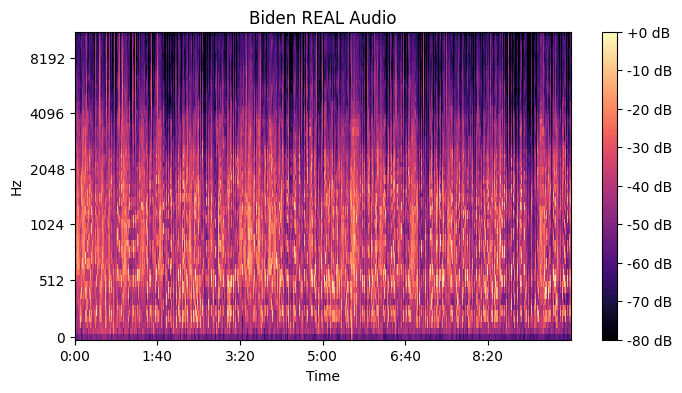

In [ ]:
# Load the audio file
file_path = 'KAGGLE/AUDIO/REAL/biden-original.wav'
waveform, sample_rate = lb.load(file_path)

# Compute the Mel spectrogram
mel_spectrogram, shape = get_mel_spectrogram(waveform, n_mels=64, sr=sample_rate)

# Plot the Mel spectrogram
plot_mel_spectrogram(mel_spectrogram, title = "Biden REAL Audio")

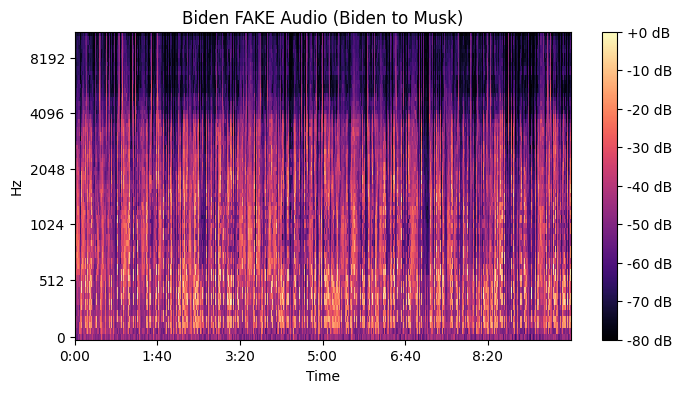

In [ ]:
# Load the audio file
file_path = 'KAGGLE/AUDIO/FAKE/biden-to-musk.wav'
waveform, sample_rate = lb.load(file_path)

# Compute the Mel spectrogram
mel_spectrogram, shape = get_mel_spectrogram(waveform, n_mels=64)

# Plot the Mel spectrogram
plot_mel_spectrogram(mel_spectrogram, title = "Biden FAKE Audio (Biden to Musk)")

In [ ]:
class AudioSpectrogramDataset(Dataset):
    def __init__(self, base_path, sample_time=3, sr=22050, n_mels=64):
        self.base_path = base_path
        self.labels = {'FAKE': 1, 'REAL': 0}
        self.file_paths = []
        self.file_labels = []
        self.sample_time = sample_time
        self.sr = sr
        self.n_mels = n_mels

        # Read the file paths and labels
        for label, value in self.labels.items():
            dir_path = os.path.join(self.base_path, label)
            files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.wav')]
            self.file_paths.extend(files)
            self.file_labels.extend([value] * len(files))

        self.samples = self._generate_samples()

    def _generate_samples(self):
        samples = []
        for file_path, label in zip(self.file_paths, self.file_labels):
            waveform, sample_rate = lb.load(file_path)
            sample_length = int(self.sample_time * sample_rate)
            full_samples_count = len(waveform) // sample_length

            for i in range(full_samples_count):
                start = i * sample_length
                end = start + sample_length
                segment = waveform[start:end]
                samples.append((segment, label))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        segment, label = self.samples[idx]

        # Convert waveform to spectrogram
        spectrogram, _ = get_mel_spectrogram(segment, n_mels=self.n_mels)
        spectrogram = np.abs(spectrogram)
        spectrogram /= 80

        return spectrogram, label

# Initialize dataset and dataloader
dataset = AudioSpectrogramDataset(base_path='KAGGLE/AUDIO')
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Example to iterate through the loader
for spectrogram, label in loader:
    print(f"Spectrogram shape: {spectrogram.shape}, Label: {label}")

Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([0, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([0, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 0, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([0, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 1, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 0, 1])
Spectrogram shape: torch.Size([4, 64, 130]), Label: tensor([1, 1, 1, 0])
Spectrogram shape: torch.Size([4, 64, 130]), Label:

In [ ]:
print(f"In total we have {len(dataset.file_paths)} audio files, from these audios we get {len(dataset.samples)} samples")

In total we have 64 audio files, from these audios we get 9976 samples


## Let's take a look a sample audio file

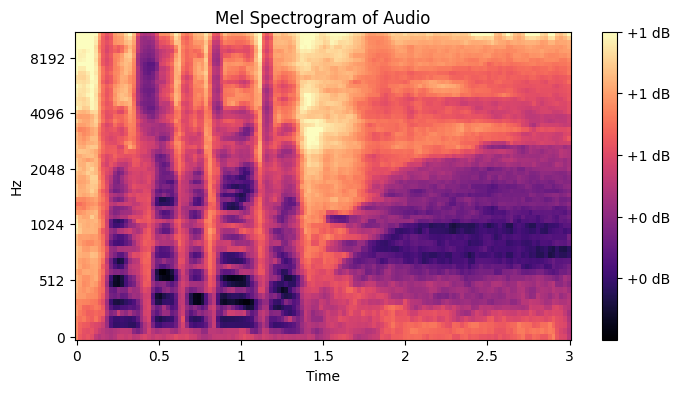

In [ ]:
plot_mel_spectrogram(dataset.__getitem__(1)[0])

In [ ]:
dataset.__getitem__(1)[1]

1

## Define Training, Validation, Test Datasets

In [ ]:
from torch.utils.data import random_split
# Define the train, validation, and test split sizes
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Define the model

In [ ]:
import torchvision.models as models
from torchvision.models.vgg import VGG16_Weights
from torchvision.models.resnet import ResNet18_Weights

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-18 and modify the final layer
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet18.conv1 = nn.Conv2d(1, resnet18.conv1.out_channels, kernel_size=resnet18.conv1.kernel_size,
                           stride=resnet18.conv1.stride, padding=resnet18.conv1.padding, bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
resnet18 = resnet18.to(device)

# Load pre-trained VGG16 and modify the final layer
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
vgg16.features[0] = nn.Conv2d(1, vgg16.features[0].out_channels, kernel_size=vgg16.features[0].kernel_size,
                              stride=vgg16.features[0].stride, padding=vgg16.features[0].padding, bias=False)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 2)
vgg16 = vgg16.to(device)

## Training the model

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, step_size=7, gamma=0.1):
    # Define the learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for inputs, labels in train_loader_tqdm:
            inputs = inputs.unsqueeze(1)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

            # Update tqdm description with current loss and accuracy
            current_loss = running_loss / total_predictions
            current_acc = correct_predictions.double() / total_predictions
            current_lr = optimizer.param_groups[0]['lr']
            train_loader_tqdm.set_postfix(train_loss=current_loss, train_acc=current_acc.item(), lr=current_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions.double() / total_predictions

        # Store training metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())


        # Step the learning rate scheduler
        scheduler.step()

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        # Store validation metrics
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        # Update tqdm description with validation results
        train_loader_tqdm.set_postfix(train_loss=epoch_loss, train_acc=epoch_acc.item(), val_loss=val_loss, val_acc=val_acc.item(), lr=current_lr)

        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
              f'LR: {current_lr:.6f}')

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.unsqueeze(1)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

    loss = running_loss / len(loader.dataset)
    acc = correct_predictions.double() / total_predictions

    return loss, acc

## Train ResNet-18

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Train ResNet-18
optimizer_resnet18 = torch.optim.Adam(resnet18.parameters(), lr=0.001)
train_model(resnet18, train_loader, val_loader, criterion, optimizer_resnet18, num_epochs=20)

Epoch 1/20: 100%|██████████| 250/250 [01:06<00:00,  3.78batch/s, lr=0.001, train_acc=0.92, train_loss=0.221]


Epoch 1/20, Train Loss: 0.2209, Train Acc: 0.9204, Val Loss: 0.1018, Val Acc: 0.9679, LR: 0.001000


Epoch 2/20: 100%|██████████| 250/250 [01:06<00:00,  3.76batch/s, lr=0.001, train_acc=0.959, train_loss=0.108]


Epoch 2/20, Train Loss: 0.1081, Train Acc: 0.9589, Val Loss: 0.1520, Val Acc: 0.9609, LR: 0.001000


Epoch 3/20: 100%|██████████| 250/250 [01:06<00:00,  3.78batch/s, lr=0.001, train_acc=0.971, train_loss=0.0791]


Epoch 3/20, Train Loss: 0.0791, Train Acc: 0.9709, Val Loss: 0.4441, Val Acc: 0.7783, LR: 0.001000


Epoch 4/20: 100%|██████████| 250/250 [01:05<00:00,  3.80batch/s, lr=0.001, train_acc=0.973, train_loss=0.0687]


Epoch 4/20, Train Loss: 0.0687, Train Acc: 0.9732, Val Loss: 0.0436, Val Acc: 0.9799, LR: 0.001000


Epoch 5/20: 100%|██████████| 250/250 [01:05<00:00,  3.80batch/s, lr=0.001, train_acc=0.97, train_loss=0.0738]


Epoch 5/20, Train Loss: 0.0738, Train Acc: 0.9703, Val Loss: 0.0568, Val Acc: 0.9729, LR: 0.001000


Epoch 6/20: 100%|██████████| 250/250 [01:06<00:00,  3.78batch/s, lr=0.001, train_acc=0.982, train_loss=0.0482]


Epoch 6/20, Train Loss: 0.0482, Train Acc: 0.9823, Val Loss: 0.0193, Val Acc: 0.9940, LR: 0.001000


Epoch 7/20: 100%|██████████| 250/250 [01:07<00:00,  3.69batch/s, lr=0.001, train_acc=0.985, train_loss=0.0369]


Epoch 7/20, Train Loss: 0.0369, Train Acc: 0.9852, Val Loss: 0.0361, Val Acc: 0.9870, LR: 0.001000


Epoch 8/20: 100%|██████████| 250/250 [01:06<00:00,  3.76batch/s, lr=0.0001, train_acc=0.991, train_loss=0.0208]


Epoch 8/20, Train Loss: 0.0208, Train Acc: 0.9907, Val Loss: 0.0138, Val Acc: 0.9930, LR: 0.000100


Epoch 9/20: 100%|██████████| 250/250 [01:06<00:00,  3.77batch/s, lr=0.0001, train_acc=0.992, train_loss=0.0182]


Epoch 9/20, Train Loss: 0.0182, Train Acc: 0.9916, Val Loss: 0.0175, Val Acc: 0.9930, LR: 0.000100


Epoch 10/20: 100%|██████████| 250/250 [01:04<00:00,  3.85batch/s, lr=0.0001, train_acc=0.994, train_loss=0.0138]


Epoch 10/20, Train Loss: 0.0138, Train Acc: 0.9942, Val Loss: 0.0109, Val Acc: 0.9970, LR: 0.000100


Epoch 11/20: 100%|██████████| 250/250 [01:09<00:00,  3.62batch/s, lr=0.0001, train_acc=0.995, train_loss=0.0118]


Epoch 11/20, Train Loss: 0.0118, Train Acc: 0.9952, Val Loss: 0.0151, Val Acc: 0.9940, LR: 0.000100


Epoch 12/20: 100%|██████████| 250/250 [01:06<00:00,  3.78batch/s, lr=0.0001, train_acc=0.995, train_loss=0.0119]


Epoch 12/20, Train Loss: 0.0119, Train Acc: 0.9952, Val Loss: 0.0119, Val Acc: 0.9940, LR: 0.000100


Epoch 13/20: 100%|██████████| 250/250 [01:05<00:00,  3.82batch/s, lr=0.0001, train_acc=0.996, train_loss=0.00911]


Epoch 13/20, Train Loss: 0.0091, Train Acc: 0.9959, Val Loss: 0.0202, Val Acc: 0.9950, LR: 0.000100


Epoch 14/20: 100%|██████████| 250/250 [01:05<00:00,  3.83batch/s, lr=0.0001, train_acc=0.996, train_loss=0.00941]


Epoch 14/20, Train Loss: 0.0094, Train Acc: 0.9962, Val Loss: 0.0115, Val Acc: 0.9970, LR: 0.000100


Epoch 15/20: 100%|██████████| 250/250 [01:05<00:00,  3.81batch/s, lr=1e-5, train_acc=0.997, train_loss=0.00741]


Epoch 15/20, Train Loss: 0.0074, Train Acc: 0.9972, Val Loss: 0.0131, Val Acc: 0.9960, LR: 0.000010


Epoch 16/20: 100%|██████████| 250/250 [01:05<00:00,  3.80batch/s, lr=1e-5, train_acc=0.997, train_loss=0.00611]


Epoch 16/20, Train Loss: 0.0061, Train Acc: 0.9975, Val Loss: 0.0151, Val Acc: 0.9950, LR: 0.000010


Epoch 17/20: 100%|██████████| 250/250 [01:05<00:00,  3.82batch/s, lr=1e-5, train_acc=0.997, train_loss=0.00626]


Epoch 17/20, Train Loss: 0.0063, Train Acc: 0.9975, Val Loss: 0.0158, Val Acc: 0.9940, LR: 0.000010


Epoch 18/20: 100%|██████████| 250/250 [01:07<00:00,  3.73batch/s, lr=1e-5, train_acc=0.998, train_loss=0.00511]


Epoch 18/20, Train Loss: 0.0051, Train Acc: 0.9980, Val Loss: 0.0139, Val Acc: 0.9960, LR: 0.000010


Epoch 19/20: 100%|██████████| 250/250 [01:06<00:00,  3.74batch/s, lr=1e-5, train_acc=0.997, train_loss=0.00559]


Epoch 19/20, Train Loss: 0.0056, Train Acc: 0.9972, Val Loss: 0.0158, Val Acc: 0.9970, LR: 0.000010


Epoch 20/20: 100%|██████████| 250/250 [01:05<00:00,  3.80batch/s, lr=1e-5, train_acc=0.998, train_loss=0.00545]


Epoch 20/20, Train Loss: 0.0055, Train Acc: 0.9980, Val Loss: 0.0166, Val Acc: 0.9960, LR: 0.000010


## Save the model

In [ ]:
# Save ResNet-18 model
torch.save(resnet18.state_dict(), 'resnet18_model_final.pth')

## Visualize the training procedure
- because I did not save the list dynamically, so I just going to hard code it

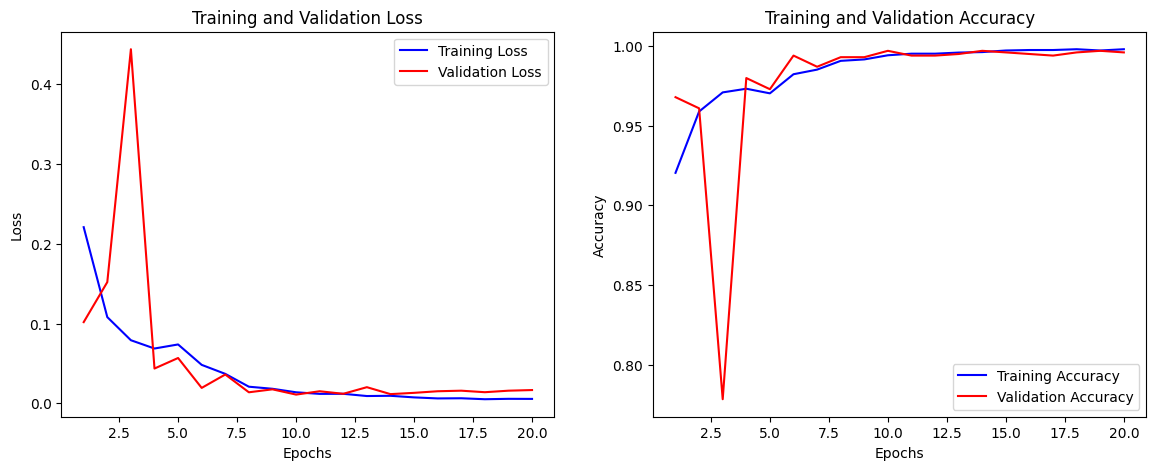

In [ ]:
num_epochs = 20
epochs = list(range(1, 21))

train_losses = [0.2209, 0.1081, 0.0791, 0.0687, 0.0738, 0.0482, 0.0369, 0.0208, 0.0182, 0.0138,
                0.0118, 0.0119, 0.0091, 0.0094, 0.0074, 0.0061, 0.0063, 0.0051, 0.0056, 0.0055]

train_accuracies = [0.9204, 0.9589, 0.9709, 0.9732, 0.9703, 0.9823, 0.9852, 0.9907, 0.9916, 0.9942,
                    0.9952, 0.9952, 0.9959, 0.9962, 0.9972, 0.9975, 0.9975, 0.9980, 0.9972, 0.9980]

val_losses = [0.1018, 0.1520, 0.4441, 0.0436, 0.0568, 0.0193, 0.0361, 0.0138, 0.0175, 0.0109,
              0.0151, 0.0119, 0.0202, 0.0115, 0.0131, 0.0151, 0.0158, 0.0139, 0.0158, 0.0166]

val_accuracies = [0.9679, 0.9609, 0.7783, 0.9799, 0.9729, 0.9940, 0.9870, 0.9930, 0.9930, 0.9970,
                  0.9940, 0.9940, 0.9950, 0.9970, 0.9960, 0.9950, 0.9940, 0.9960, 0.9970, 0.9960]

# Plotting function
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot the metrics
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs)

## Evaluate our Fine-Tuned Model

In [ ]:
def test_model(model, loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.unsqueeze(1)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

    acc = correct_predictions.double() / total_predictions
    print(f'Test Acc: {acc:.4f}')

test_model(resnet18, test_loader)

Test Acc: 0.9960


## Take a audio file as an example

In [ ]:
# Define the function to classify audio segments
def classify_audio(model, file_path, sample_time = 3, sample_rate = 22050):
    model.eval()
    fake_count = 0
    total_count = 0

    # Load the audio file
    waveform, sample_rate = lb.load(file_path)
    print(sample_rate)
    sample_length = int(sample_time * sample_rate)
    full_samples_count = len(waveform) // sample_length

    for i in range(full_samples_count):
        start = i * sample_length
        end = start + sample_length
        segment = waveform[start:end]

        # Compute the Mel spectrogram
        mel_spectrogram, shape = get_mel_spectrogram(segment, n_mels=64)

        mel_spectrogram = np.abs(mel_spectrogram)
        mel_spectrogram /= 80

        mel_spectrogram = mel_spectrogram.unsqueeze(1).to(device)
        outputs = model(mel_spectrogram)
        _, preds = torch.max(outputs, 1)
        fake_count += (preds == 1).sum().item()
        total_count += preds.size(0)


    return fake_count, total_count

## Load Model

In [ ]:
# Load the fine-tuned ResNet-18 model
def load_resnet18_model(model_path):
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size,
                                  stride=model.conv1.stride, padding=model.conv1.padding, bias=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    return model

resnet18_model_final = load_resnet18_model('resnet18_model_final.pth')

## Classify the fake and real audio

In [ ]:
def classify_audio(model, file_path, sample_time=3, sample_rate=22050, n_mels=64):
    model.eval()
    fake_count = 0
    total_count = 0

    # Load the audio file
    waveform, sample_rate = lb.load(file_path, sr=sample_rate)
    sample_length = int(sample_time * sample_rate)
    full_samples_count = len(waveform) // sample_length

    for i in range(full_samples_count):
        start = i * sample_length
        end = start + sample_length
        segment = waveform[start:end]

        # Compute the Mel spectrogram
        mel_spectrogram, _ = get_mel_spectrogram(segment, sr=sample_rate, n_mels=n_mels)
        mel_spectrogram = np.abs(mel_spectrogram)
        mel_spectrogram /= 80

        # Convert to tensor and add batch dimension
        mel_spectrogram = torch.tensor(mel_spectrogram).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float)

        # Get model predictions
        outputs = model(mel_spectrogram)
        _, preds = torch.max(outputs, 1)
        fake_count += (preds == 1).sum().item()
        total_count += preds.size(0)

    # Determine if the audio is fake or real
    fake_percentage = fake_count / total_count
    if fake_percentage > 0.1:
        result = "FAKE"
    else:
        result = "REAL"

    print(f"Fake Count: {fake_count}, Total Count: {total_count}, Fake Percentage: {fake_percentage:.2%}")
    print(f"Audio is {result}")
    return result

In [ ]:
file_path = 'KAGGLE/AUDIO/FAKE/biden-to-musk.wav'
result = classify_audio(resnet18_model_final, file_path, sample_time=3, sample_rate=22050, n_mels=64)

Fake Count: 200, Total Count: 200, Fake Percentage: 100.00%
Audio is FAKE


In [ ]:
file_path = '/content/KAGGLE/AUDIO/REAL/musk-original.wav'
result = classify_audio(resnet18_model_final, file_path, sample_time=3, sample_rate=22050, n_mels=64)

Fake Count: 1, Total Count: 200, Fake Percentage: 0.50%
Audio is REAL


In [ ]:
file_path = '/content/KAGGLE/AUDIO/REAL/biden-original.wav'
result = classify_audio(resnet18_model_final, file_path, sample_time=3, sample_rate=22050, n_mels=64)

Fake Count: 3, Total Count: 200, Fake Percentage: 1.50%
Audio is REAL


In [ ]:
file_path = '/content/KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav'
result = classify_audio(resnet18_model_final, file_path, sample_time=3, sample_rate=22050, n_mels=64)

Fake Count: 200, Total Count: 200, Fake Percentage: 100.00%
Audio is FAKE


In [ ]:
file_path = '/content/KAGGLE/AUDIO/REAL/obama-original.wav'
result = classify_audio(resnet18_model_final, file_path, sample_time=3, sample_rate=22050, n_mels=64)

Fake Count: 8, Total Count: 200, Fake Percentage: 4.00%
Audio is REAL


## Custom Models (CNN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 8, 512)
        self.fc2 = nn.Linear(512, 2)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch_size, 32, 32, 65]
        x = self.pool(F.relu(self.conv2(x)))  # [batch_size, 64, 16, 33]
        x = self.pool(F.relu(self.conv3(x)))  # [batch_size, 128, 8, 16]
        x = self.pool(F.relu(self.conv4(x)))  # [batch_size, 256, 4, 8]

        x = x.view(-1, 256 * 4 * 8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

custom_model = CustomCNN().to(device)
print(custom_model)


CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
cnn_optimizer = optim.Adam(custom_model.parameters(), lr=0.001)
train_model(custom_model, train_loader, val_loader, criterion, cnn_optimizer, num_epochs=20,  step_size = 7)

Epoch 1/20: 100%|██████████| 250/250 [01:00<00:00,  4.10batch/s, lr=0.001, train_acc=0.882, train_loss=0.317]


Epoch 1/20, Train Loss: 0.3173, Train Acc: 0.8822, Val Loss: 0.2236, Val Acc: 0.8987, LR: 0.001000


Epoch 2/20: 100%|██████████| 250/250 [01:02<00:00,  3.99batch/s, lr=0.001, train_acc=0.921, train_loss=0.217]


Epoch 2/20, Train Loss: 0.2168, Train Acc: 0.9213, Val Loss: 0.1378, Val Acc: 0.9539, LR: 0.001000


Epoch 3/20: 100%|██████████| 250/250 [00:59<00:00,  4.20batch/s, lr=0.001, train_acc=0.942, train_loss=0.163]


Epoch 3/20, Train Loss: 0.1633, Train Acc: 0.9416, Val Loss: 0.1238, Val Acc: 0.9559, LR: 0.001000


Epoch 4/20: 100%|██████████| 250/250 [00:59<00:00,  4.21batch/s, lr=0.001, train_acc=0.952, train_loss=0.136]


Epoch 4/20, Train Loss: 0.1357, Train Acc: 0.9516, Val Loss: 0.1178, Val Acc: 0.9509, LR: 0.001000


Epoch 5/20: 100%|██████████| 250/250 [00:59<00:00,  4.21batch/s, lr=0.001, train_acc=0.959, train_loss=0.114]


Epoch 5/20, Train Loss: 0.1139, Train Acc: 0.9588, Val Loss: 0.0781, Val Acc: 0.9669, LR: 0.001000


Epoch 6/20: 100%|██████████| 250/250 [00:59<00:00,  4.22batch/s, lr=0.001, train_acc=0.965, train_loss=0.0952]


Epoch 6/20, Train Loss: 0.0952, Train Acc: 0.9648, Val Loss: 0.1135, Val Acc: 0.9569, LR: 0.001000


Epoch 7/20: 100%|██████████| 250/250 [00:59<00:00,  4.21batch/s, lr=0.001, train_acc=0.97, train_loss=0.0747]


Epoch 7/20, Train Loss: 0.0747, Train Acc: 0.9699, Val Loss: 0.0511, Val Acc: 0.9809, LR: 0.001000


Epoch 8/20: 100%|██████████| 250/250 [00:59<00:00,  4.20batch/s, lr=0.0001, train_acc=0.985, train_loss=0.0387]


Epoch 8/20, Train Loss: 0.0387, Train Acc: 0.9850, Val Loss: 0.0347, Val Acc: 0.9840, LR: 0.000100


Epoch 9/20: 100%|██████████| 250/250 [00:59<00:00,  4.22batch/s, lr=0.0001, train_acc=0.987, train_loss=0.0318]


Epoch 9/20, Train Loss: 0.0318, Train Acc: 0.9875, Val Loss: 0.0315, Val Acc: 0.9860, LR: 0.000100


Epoch 10/20: 100%|██████████| 250/250 [00:59<00:00,  4.23batch/s, lr=0.0001, train_acc=0.989, train_loss=0.0284]


Epoch 10/20, Train Loss: 0.0284, Train Acc: 0.9893, Val Loss: 0.0314, Val Acc: 0.9860, LR: 0.000100


Epoch 11/20: 100%|██████████| 250/250 [01:00<00:00,  4.15batch/s, lr=0.0001, train_acc=0.989, train_loss=0.0261]


Epoch 11/20, Train Loss: 0.0261, Train Acc: 0.9893, Val Loss: 0.0307, Val Acc: 0.9890, LR: 0.000100


Epoch 12/20: 100%|██████████| 250/250 [00:59<00:00,  4.22batch/s, lr=0.0001, train_acc=0.991, train_loss=0.0219]


Epoch 12/20, Train Loss: 0.0219, Train Acc: 0.9906, Val Loss: 0.0285, Val Acc: 0.9890, LR: 0.000100


Epoch 13/20: 100%|██████████| 250/250 [00:58<00:00,  4.24batch/s, lr=0.0001, train_acc=0.991, train_loss=0.0222]


Epoch 13/20, Train Loss: 0.0222, Train Acc: 0.9912, Val Loss: 0.0310, Val Acc: 0.9890, LR: 0.000100


Epoch 14/20: 100%|██████████| 250/250 [00:59<00:00,  4.20batch/s, lr=0.0001, train_acc=0.991, train_loss=0.0197]


Epoch 14/20, Train Loss: 0.0197, Train Acc: 0.9910, Val Loss: 0.0340, Val Acc: 0.9850, LR: 0.000100


Epoch 15/20: 100%|██████████| 250/250 [00:57<00:00,  4.31batch/s, lr=1e-5, train_acc=0.994, train_loss=0.0166]


Epoch 15/20, Train Loss: 0.0166, Train Acc: 0.9936, Val Loss: 0.0289, Val Acc: 0.9870, LR: 0.000010


Epoch 16/20: 100%|██████████| 250/250 [00:58<00:00,  4.26batch/s, lr=1e-5, train_acc=0.994, train_loss=0.0161]


Epoch 16/20, Train Loss: 0.0161, Train Acc: 0.9937, Val Loss: 0.0286, Val Acc: 0.9860, LR: 0.000010


Epoch 17/20: 100%|██████████| 250/250 [00:59<00:00,  4.20batch/s, lr=1e-5, train_acc=0.994, train_loss=0.0151]


Epoch 17/20, Train Loss: 0.0151, Train Acc: 0.9939, Val Loss: 0.0282, Val Acc: 0.9860, LR: 0.000010


Epoch 18/20: 100%|██████████| 250/250 [00:58<00:00,  4.25batch/s, lr=1e-5, train_acc=0.993, train_loss=0.0151]


Epoch 18/20, Train Loss: 0.0151, Train Acc: 0.9935, Val Loss: 0.0282, Val Acc: 0.9870, LR: 0.000010


Epoch 19/20: 100%|██████████| 250/250 [00:59<00:00,  4.18batch/s, lr=1e-5, train_acc=0.995, train_loss=0.0145]


Epoch 19/20, Train Loss: 0.0145, Train Acc: 0.9949, Val Loss: 0.0282, Val Acc: 0.9870, LR: 0.000010


Epoch 20/20: 100%|██████████| 250/250 [00:58<00:00,  4.26batch/s, lr=1e-5, train_acc=0.995, train_loss=0.0147]


Epoch 20/20, Train Loss: 0.0147, Train Acc: 0.9946, Val Loss: 0.0279, Val Acc: 0.9870, LR: 0.000010


In [ ]:
test_model(custom_model, test_loader)

Test Acc: 0.9780


## Save the model

In [ ]:
# Save ResNet-18 model
torch.save(custom_model.state_dict(), 'custom_model_final.pth')

## Visualize the custom models
(I will still hard code it because I did not save it during training)

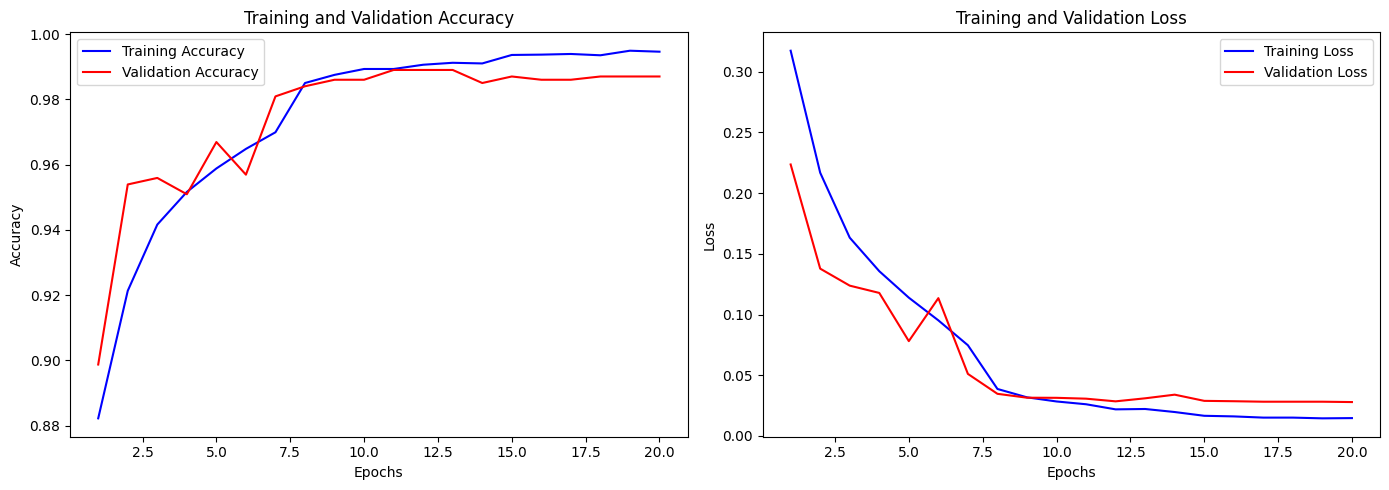

In [ ]:
# Data from training logs
epochs = list(range(1, 21))

train_acc = [0.8822, 0.9213, 0.9416, 0.9516, 0.9588, 0.9648, 0.9699, 0.9850, 0.9875, 0.9893,
             0.9893, 0.9906, 0.9912, 0.9910, 0.9936, 0.9937, 0.9939, 0.9935, 0.9949, 0.9946]

train_loss = [0.3173, 0.2168, 0.1633, 0.1357, 0.1139, 0.0952, 0.0747, 0.0387, 0.0318, 0.0284,
              0.0261, 0.0219, 0.0222, 0.0197, 0.0166, 0.0161, 0.0151, 0.0151, 0.0145, 0.0147]

val_acc = [0.8987, 0.9539, 0.9559, 0.9509, 0.9669, 0.9569, 0.9809, 0.9840, 0.9860, 0.9860,
           0.9890, 0.9890, 0.9890, 0.9850, 0.9870, 0.9860, 0.9860, 0.9870, 0.9870, 0.9870]

val_loss = [0.2236, 0.1378, 0.1238, 0.1178, 0.0781, 0.1135, 0.0511, 0.0347, 0.0315, 0.0314,
            0.0307, 0.0285, 0.0310, 0.0340, 0.0289, 0.0286, 0.0282, 0.0282, 0.0282, 0.0279]

# Plotting the metrics
plt.figure(figsize=(14, 5))

# Plot train and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot train and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from torchsummary import summary
input_size = (1, 64, 130)
summary(custom_model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 64, 130]             320
         MaxPool2d-2           [-1, 32, 32, 65]               0
            Conv2d-3           [-1, 64, 32, 65]          18,496
         MaxPool2d-4           [-1, 64, 16, 32]               0
            Conv2d-5          [-1, 128, 16, 32]          73,856
         MaxPool2d-6           [-1, 128, 8, 16]               0
            Conv2d-7           [-1, 256, 8, 16]         295,168
         MaxPool2d-8            [-1, 256, 4, 8]               0
            Linear-9                  [-1, 512]       4,194,816
          Dropout-10                  [-1, 512]               0
           Linear-11                    [-1, 2]           1,026
Total params: 4,583,682
Trainable params: 4,583,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forw

In [ ]:
summary(resnet18, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 65]           3,136
       BatchNorm2d-2           [-1, 64, 32, 65]             128
              ReLU-3           [-1, 64, 32, 65]               0
         MaxPool2d-4           [-1, 64, 16, 33]               0
            Conv2d-5           [-1, 64, 16, 33]          36,864
       BatchNorm2d-6           [-1, 64, 16, 33]             128
              ReLU-7           [-1, 64, 16, 33]               0
            Conv2d-8           [-1, 64, 16, 33]          36,864
       BatchNorm2d-9           [-1, 64, 16, 33]             128
             ReLU-10           [-1, 64, 16, 33]               0
       BasicBlock-11           [-1, 64, 16, 33]               0
           Conv2d-12           [-1, 64, 16, 33]          36,864
      BatchNorm2d-13           [-1, 64, 16, 33]             128
             ReLU-14           [-1, 64,